In [50]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import dask
import csv
import seaborn as sns
from pathlib import Path


In [2]:
%env AWS_PROFILE = dynamodbSobCap

env: AWS_PROFILE=dynamodbSobCap


In [3]:
s3 = boto3.resource("s3")
bucket = s3.Bucket('sobesice-capital-data')

# now bucket is "attached" the S3 bucket name "mybucket"
print(bucket)
# s3.Bucket(name='mybucket')

print(dir(bucket))
#show you all class method action you may perform

s3.Bucket(name='sobesice-capital-data')
['Acl', 'Cors', 'Lifecycle', 'LifecycleConfiguration', 'Logging', 'Notification', 'Object', 'Policy', 'RequestPayment', 'Tagging', 'Versioning', 'Website', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_name', 'copy', 'create', 'creation_date', 'delete', 'delete_objects', 'download_file', 'download_fileobj', 'get_available_subresources', 'load', 'meta', 'multipart_uploads', 'name', 'object_versions', 'objects', 'put_object', 'upload_file', 'upload_fileobj', 'wait_until_exists', 'wait_until_not_exists']


In [4]:
# %%timeit
obj = bucket.Object("crypto-data/bitmex/quotes/XBTUSD/2020-12-20.csv").get()
data = pd.read_csv(obj['Body'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189702 entries, 0 to 2189701
Data columns (total 5 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   2020-12-20T00:00:00.871Z  object 
 1   23870                     float64
 2   23870.5                   float64
 3   278545                    int64  
 4   588435                    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 83.5+ MB


In [8]:
def read_boto_obj_to_df(ticker, date, style):
    """
    Read raw csv to pandas DF
      - type quotes or trades
    """
    root_path = 'crypto-data/bitmex/'
    if style == 'quotes':
        nms = ['timestamp', 'bid', 'ask', 'bidsize', 'asksize']
    elif style == 'trans':
        nms = ['timestamp', 'ordertype', 'volume', 'price', 'ticktype']
    else:
        raise ValueError("Unknown data processing type. Supported types are 'quotes' and ' trans'.")

    path = os.path.join(root_path, style + '/', ticker + '/', date + '.csv')
    print(path)
    obj = bucket.Object(path).get()
    
    df = pd.read_csv(obj['Body'], header=None, names=nms, parse_dates=True)
    df.index = pd.to_datetime(df.timestamp)
    return df

In [10]:
btc_trade = read_boto_obj_to_df('XBTUSD', '2020-11-20', 'trans')

crypto-data/bitmex/trans/XBTUSD/2020-11-20.csv


In [11]:
btc_quote = read_boto_obj_to_df('XBTUSD', '2020-11-20', 'quotes')

crypto-data/bitmex/quotes/XBTUSD/2020-11-20.csv


In [47]:
start_time = btc_quote.index[0]
end_time = start_time + pd.Timedelta('100s')
btc_quote_slice = btc_quote[(btc_quote.index >= start_time) & (btc_quote.index<=end_time)]

In [13]:
btc_trade[(btc_trade.index >= start_time) & (btc_trade.index<=end_time)]

,timestamp,ordertype,volume,price,ticktype
timestamp,,,,,
2020-11-20 00:00:00.993000+00:00,2020-11-20T00:00:00.993Z,Sell,640,17823.5,MinusTick
2020-11-20 00:00:00.993000+00:00,2020-11-20T00:00:00.993Z,Sell,1257,17823.5,ZeroMinusTick
2020-11-20 00:00:01.020000+00:00,2020-11-20T00:00:01.020Z,Buy,10,17824.0,PlusTick
2020-11-20 00:00:01.026000+00:00,2020-11-20T00:00:01.026Z,Buy,11,17824.0,ZeroPlusTick


In [14]:
btc_quote.join(btc_trade, how='inner', lsuffix='_left', rsuffix='_right').shape

(379792, 10)

In [27]:
btc_trade.index

DatetimeIndex(['2020-11-20 00:00:00.993000+00:00',
               '2020-11-20 00:00:00.993000+00:00',
               '2020-11-20 00:00:01.020000+00:00',
               '2020-11-20 00:00:01.026000+00:00',
               '2020-11-20 00:00:02.311000+00:00',
               '2020-11-20 00:00:02.317000+00:00',
               '2020-11-20 00:00:02.329000+00:00',
               '2020-11-20 00:00:02.342000+00:00',
               '2020-11-20 00:00:02.342000+00:00',
               '2020-11-20 00:00:02.342000+00:00',
               ...
               '2020-11-20 23:59:52.607000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
               '2020-11-20 23:59:58.714000+00:00',
            

In [29]:
btc_quote.join(btc_trade, how='outer')

ValueError: columns overlap but no suffix specified: Index(['timestamp'], dtype='object')

In [41]:
merged_btc_outter = btc_quote.join(btc_trade, how='outer', lsuffix='_left', rsuffix='_right')
merged_btc_inner = btc_quote.join(btc_trade, how='inner', lsuffix='_left', rsuffix='_right')
print(btc_trade.shape)
print(btc_quote.shape)
print(merged.shape)
print(merged_btc_outter[~pd.isna(merged_btc_outter.timestamp_right)].shape)

(378892, 5)
(2263566, 5)
(2486118, 10)
(380051, 10)


In [52]:
str(Path.home())

'/Users/mmark'

In [40]:
merged_btc_outter.head(50)

,timestamp_left,bid,ask,bidsize,asksize,timestamp_right,ordertype,volume,price,ticktype
timestamp,,,,,,,,,,
2020-11-20 00:00:00.943000+00:00,2020-11-20T00:00:00.943Z,17823.5,17824.0,19453.0,1151985.0,NaN,NaN,NaN,NaN,NaN
2020-11-20 00:00:00.949000+00:00,2020-11-20T00:00:00.949Z,17823.5,17824.0,19453.0,1151937.0,NaN,NaN,NaN,NaN,NaN
2020-11-20 00:00:00.951000+00:00,2020-11-20T00:00:00.951Z,17823.5,17824.0,26021.0,1151937.0,NaN,NaN,NaN,NaN,NaN
2020-11-20 00:00:00.956000+00:00,2020-11-20T00:00:00.956Z,17823.5,17824.0,27896.0,1151937.0,NaN,NaN,NaN,NaN,NaN
2020-11-20 00:00:00.962000+00:00,2020-11-20T00:00:00.962Z,17823.5,17824.0,28311.0,1151937.0,NaN,NaN,NaN,NaN,NaN
2020-11-20 00:00:00.993000+00:00,2020-11-20T00:00:00.993Z,17823.5,17824.0,26414.0,1151937.0,2020-11-20T00:00:00.993Z,Sell,640.0,17823.5,MinusTick
2020-11-20 00:00:00.993000+00:00,2020-11-20T00:00:00.993Z,17823.5,17824.0,26414.0,1151937.0,2020-11-20T00:00:00.993Z,Sell,1257.0,17823.5,ZeroMinusTick
2020-11-20 00:00:00.996000+00:00,2020-11-20T00:00:00.996Z,17823.5,17824.0,26414.0,1181943.0,NaN,NaN,NaN,NaN,NaN
2020-11-20 00:00:01.014000+00:00,2020-11-20T00:00:01.014Z,17823.5,17824.0,26414.0,1184443.0,NaN,NaN,NaN,NaN,NaN


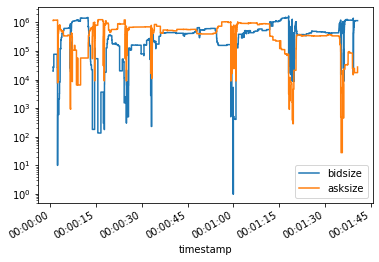

In [49]:
btc_quote_slice[['bidsize', 'asksize']].plot(drawstyle="steps-post")
plt.yscale('log')

In [ ]:
os.geth

In [ ]:
def bin_index(df, bin_size):
    remainder = btc.price%bin_size
    df[remainder!=0] + 

In [74]:
cut, bins = pd.cut(slice1.price, 15, retbins=True)

In [75]:
slice1.groupby(pd.cut(slice1.price, 15)).sum().volume

price
(17805.864, 17815.1]    1006937
(17815.1, 17824.2]       394322
(17824.2, 17833.3]       607847
(17833.3, 17842.4]       600754
(17842.4, 17851.5]      1260373
(17851.5, 17860.6]      1513516
(17860.6, 17869.7]       404594
(17869.7, 17878.8]      1101847
(17878.8, 17887.9]      6160948
(17887.9, 17897.0]      6734039
(17897.0, 17906.1]      4689832
(17906.1, 17915.2]      5465378
(17915.2, 17924.3]      6196717
(17924.3, 17933.4]      1510309
(17933.4, 17942.5]      4002174
Name: volume, dtype: int64

In [85]:
profile = slice1.groupby(pd.cut(slice1.price, 20)).sum().volume
profile

price
(17805.864, 17812.825]     858610
(17812.825, 17819.65]      256331
(17819.65, 17826.475]      428213
(17826.475, 17833.3]       465952
(17833.3, 17840.125]       345523
(17840.125, 17846.95]      411602
(17846.95, 17853.775]     1566202
(17853.775, 17860.6]      1051316
(17860.6, 17867.425]       173736
(17867.425, 17874.25]      596061
(17874.25, 17881.075]     2370588
(17881.075, 17887.9]      4527004
(17887.9, 17894.725]      5314260
(17894.725, 17901.55]     5131434
(17901.55, 17908.375]     2608466
(17908.375, 17915.2]      3835089
(17915.2, 17922.025]      6025971
(17922.025, 17928.85]      952781
(17928.85, 17935.675]     2903459
(17935.675, 17942.5]      1826989
Name: volume, dtype: int64

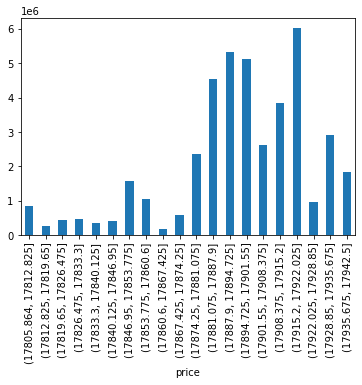

In [86]:
profile.plot.bar()

AttributeError: module 'matplotlib.pyplot' has no attribute 'barplot'

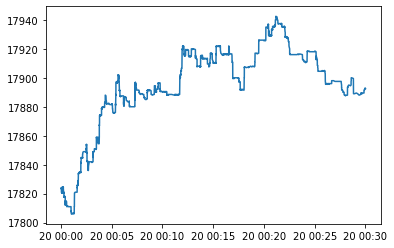

In [88]:
plt.plot(slice1.price)
plt.barplot(profile)

In [ ]:
plt.bar()

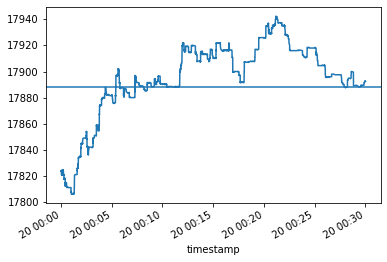

In [77]:
slice1.price.plot()
plt.axhline(bins[9])

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


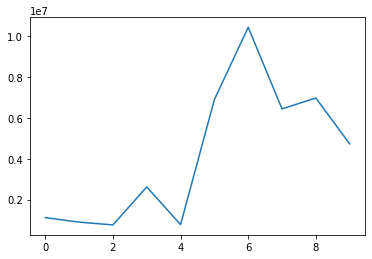

In [51]:
plt.plot(slice1.groupby(pd.cut(slice1.price, 10)).sum().volume)

In [26]:
slice1 = btc[btc.index < btc.index[0] + pd.Timedelta('30min')]

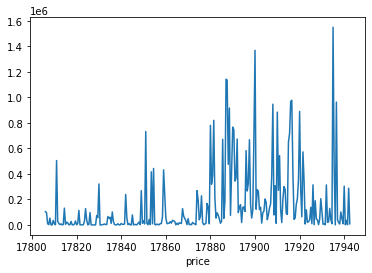

In [24]:
slice1.groupby('price').volume.sum().plot()

In [ ]:
ticker = BCHUSD
'crypto-data/bitmex/quotes/' + ticker +

In [126]:
def get_instruments(style='trans'):
    if style == 'quotes':
        dirty_inst_list = [key.key.split('/')[3] for key in bucket.objects.filter(Prefix='crypto-data/bitmex/quotes/')]
    elif style == 'trans':
        dirty_inst_list = [key.key.split('/')[3] for key in bucket.objects.filter(Prefix='crypto-data/bitmex/trans/')]
    else:
        raise ValueError("Supported style are limitted to 'trans' and 'quotes'.")
    unique_list = list(set(dirty_inst_list))
    return unique_list

In [242]:
def get_availability(instrument, style='trans', verbose=True):
    if style not in ['trans', 'quotes']:
        raise ValueError("Supported style are limitted to 'trans' and 'quotes'.")
    else:
        path = 'crypto-data/bitmex/' + style + '/' + instrument
    avail = pd.Series(pd.to_datetime([key.key.split('/')[-1].split('.')[0] for key in bucket.objects.filter(Prefix=path)]).sort_values())
    start_date = avail.iloc[0].date()
    end_date = avail.iloc[-1].date()
    missing = pd.Series(pd.date_range(start = start_date, end = end_date).difference(avail))
    
    if verbose:
        print(f'Total days: {len(avail)}')
        print(f'Missing days: {len(missing)}, i.e., {(len(missing))/(len(missing) + len(avail)) * 100:.2f} % missing.')
        print(f'First date of data: {start_date}')
        print(f'Last date of data: {end_date}')
        
    return avail, missing

In [243]:
dates, missing = get_availability('BCH', 'trans', verbose=True)

Total days: 155
Missing days: 467, i.e., 75.08 % missing.
First date of data: 2019-04-11
Last date of data: 2020-12-22


In [229]:
dates.iloc[-1] - dates.iloc[0]

Timedelta('621 days 00:00:00')

In [215]:
pd.date_range(start = '2019-04-11', end = ' 2020-12-22' ).difference(dates)

(467,)

In [240]:
missing

DatetimeIndex(['2019-07-01', '2019-07-03', '2019-07-04', '2019-07-06',
               '2019-07-10', '2019-07-13', '2019-07-15', '2019-07-18',
               '2019-07-20', '2019-07-21',
               ...
               '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10',
               '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14',
               '2020-11-15', '2020-11-16'],
              dtype='datetime64[ns]', length=467, freq=None)

In [241]:
dates[dates.diff().dt.days != 1] - pd.Timedelta(days=1)

0     2019-04-10
81    2019-07-01
82    2019-07-04
83    2019-07-06
86    2019-07-10
88    2019-07-13
89    2019-07-15
91    2019-07-18
92    2019-07-22
93    2019-07-25
94    2019-07-29
99    2019-08-04
100   2019-08-06
102   2019-08-11
103   2019-08-15
104   2019-08-19
107   2019-08-26
109   2019-09-02
112   2019-09-08
113   2019-09-18
114   2019-09-23
116   2019-09-29
117   2019-10-01
118   2019-10-09
119   2020-11-16
dtype: datetime64[ns]

In [212]:
dates.iloc[115:121]

115   2019-09-25
116   2019-09-30
117   2019-10-02
118   2019-10-10
119   2020-11-17
120   2020-11-18
dtype: datetime64[ns]

In [175]:
dates.astype('ordinal')

TypeError: data type "ordinal" not understood

In [174]:
dates

DatetimeIndex(['2019-04-11', '2019-04-12', '2019-04-13', '2019-04-14',
               '2019-04-15', '2019-04-16', '2019-04-17', '2019-04-18',
               '2019-04-19', '2019-04-20',
               ...
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22'],
              dtype='datetime64[ns]', length=155, freq=None)

In [168]:
len(dates)

35

In [127]:
get_instruments('quotes')

['XBTUSD', 'LTCUSD', 'LINKUSDT', 'XRPUSD', 'ETHUSD', 'BCHUSD']

In [128]:
get_instruments('trans')

['EOSM19',
 'BCHM19',
 'XRPM19',
 'ADAM19',
 'TRXM19',
 'LTCM19',
 'navidrak',
 'XBTUSD',
 'LTCUSD',
 'LINKUSDT',
 'XRPUSD',
 'ETHUSD',
 'BCHUSD']

In [122]:
a = get_instruments('quotes')

In [120]:
a[0].split('/')[3]

'BCHUSD'

In [107]:
a[0].key

'crypto-data/bitmex/trans/ADAM19/2019-04-11.csv'

In [ ]:
def check_availablility(intruments):
    list(bucket.objects.filter(Prefix='crypto-data/bitmex/quotes/' + 'ticker'))

In [98]:
[ob.key for ob in bucket.objects.filter(Prefix='crypto-data/bitmex/')]

['crypto-data/bitmex/quotes/BCHUSD/2020-11-17.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-18.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-19.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-20.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-21.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-22.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-23.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-24.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-25.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-26.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-27.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-28.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-29.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-30.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-12-01.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-12-02.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-12-03.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-12-04.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-12-05.csv',
 'crypto-dat

In [11]:
list(bucket.objects.filter(Prefix='crypto-data/'))

[s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-17.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-18.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-19.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-20.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-21.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-22.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-23.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-24.csv'),
 s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-25.csv'),
 

In [12]:
for my_bucket_object in bucket.objects.all():
    print(my_bucket_object)

s3.ObjectSummary(bucket_name='sobesice-capital-data', key='Honza-backup-smartvue.zip')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-17.csv')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-18.csv')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-19.csv')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-20.csv')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-21.csv')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-22.csv')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-23.csv')
s3.ObjectSummary(bucket_name='sobesice-capital-data', key='crypto-data/bitmex/quotes/BCHUSD/2020-11-24.csv')
s3.ObjectSummary(bucket_name='sobesice-ca

In [14]:
bucket.objects.all()

s3.Bucket.objectsCollection(s3.Bucket(name='sobesice-capital-data'), s3.ObjectSummary)